In [1]:
########################################################################################################################
#                                                          IMPORT                                                      #
########################################################################################################################
import torch
import sys
sys.path.append('..')
import os
import json
import time
import numpy as np
import argparse

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, DVILoss, DummyTemporalLoss
from singleVis.edge_dataset import VisDataHandler
from singleVis.trainer import VISTrainer
from singleVis.eval.evaluator import Evaluator
from singleVis.data import NormalDataProvider
from trustVis.sampeling import CriticalSampling
from singleVis.spatial_edge_constructor import Trustvis_SpatialEdgeConstructor, TrustvisTemporalSpatialEdgeConstructor

from singleVis.utils import _construct_fuzzy_complex

from singleVis.projector import VISProjector

import torch.nn.functional as F
########################################################################################################################
#                                                      PARAMETERS                                                   #
########################################################################################################################
"""This serve as an example of DeepVisualInsight implementation in pytorch."""
VIS_METHOD = "DVI" #

########################################################################################################################
#                                                     LOAD PARAMETERS                                                  #
########################################################################################################################


parser = argparse.ArgumentParser(description='Process hyperparameters...')

# get workspace dir
current_path = os.getcwd()

parent_path = os.path.dirname(current_path)

new_path = os.path.join(parent_path, 'training_dynamic')


CONTENT_PATH = '/home/yifan/dataset/case_study_mnist_backdoor'
sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]

CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
PREPROCESS = config["VISUALIZATION"]["PREPROCESS"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

EPOCH_START = 42
EPOCH_END = 42
epoch = EPOCH_START
# EPOCH_START = 1
# EPOCH_END = 50
EPOCH_PERIOD = 1

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
LAMBDA1 = 1
LAMBDA2 = VISUALIZATION_PARAMETER["LAMBDA2"]
B_N_EPOCHS = 0
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]
VIS_MODEL_NAME = 'trustvis_tempo' ### saved_as VIS_MODEL_NAME.pth
# Define hyperparameters
GPU_ID = 0
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")
print("device", DEVICE)           

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, epoch_name='Epoch',classes=CLASSES,verbose=1)
# Define visualization models
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
# Define Losses
negative_sample_rate = 5
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-21 21:17:34.432645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 21:17:34.981409: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-21 21:17:34.981460: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinf

device cuda:0
Finish initialization...


100%|██████████| 300/300 [00:00<00:00, 549.85it/s]


Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


100%|██████████| 300/300 [00:00<00:00, 6130.44it/s]


conf_error number: 917
Successfully load the DVI visualization model for iteration 42
Computing decision regions ...
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42
grid_samples (160000, 512)


100%|██████████| 800/800 [00:00<00:00, 3216.11it/s]


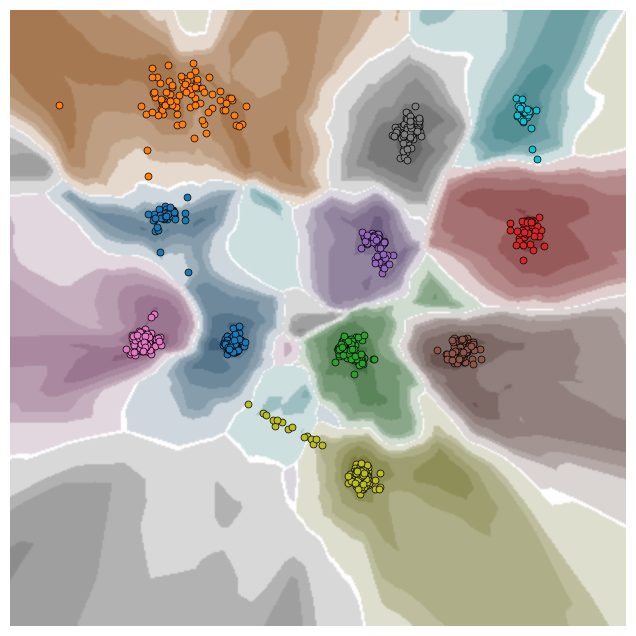

In [2]:
projector = VISProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device=DEVICE)
path = "/home/yifan/dataset/case_study_mnist_backdoor/clean_label.json"
with open(path, "r") as f:
    clean_label = json.load(f)
    
with open("/home/yifan/dataset/case_study_mnist_backdoor/noisy_label.json", "r") as f:
    noise_label = json.load(f)

noise_indicates = []
for i in range(len(clean_label)):
    if clean_label[i] != noise_label[i]:
        noise_indicates.append(i)

save_dir = os.path.join(data_provider.content_path, VIS_MODEL_NAME)
train_data = data_provider.train_representation(epoch)
labels = data_provider.train_labels(epoch)

train_data = train_data.reshape(train_data.shape[0],train_data.shape[1])

pred = data_provider.get_pred(epoch, train_data)
new_pred_Res = pred.argmax(axis=1)

emb = projector.batch_project(epoch,train_data)
indicates = noise_indicates

sort_preds = np.sort(pred, axis=1)
diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])

inv = projector.batch_inverse(epoch, emb)
inv_pred = data_provider.get_pred(epoch, inv)
inv_sort_preds = np.sort(inv_pred, axis=1)
inv_diff = (inv_sort_preds[:, -1] - inv_sort_preds[:, -2]) / (inv_sort_preds[:, -1] - inv_sort_preds[:, 0])
conf_error = []
for i in range(len(diff)):
    if abs(diff[i] - inv_diff[i]) > 0.2:
        conf_error.append(i)
print("conf_error number:", len(conf_error))
# from singleVis.eval.evaluate import *
# val = evaluate_proj_nn_perseverance_knn(train_data, emb, n_neighbors=15, metric="euclidean")
from singleVis.visualizer import visualizer
now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 
vis = visualizer(data_provider, projector, 400, "tab10")
vis.savefig_custom(epoch, path=os.path.join(save_dir, "{}_{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD,now)),
            pred=new_pred_Res[conf_error],
            train_labels=new_pred_Res[conf_error], 
            embedding=emb[conf_error])

(array([    1,    21,    23, ..., 59965, 59972, 59987]),)

In [51]:
#### next we will retrain the model that freeze decoder: inv_grid is fixed. 

In [3]:
spatial_cons = Trustvis_SpatialEdgeConstructor(data_provider, epoch, S_N_EPOCHS, B_N_EPOCHS, N_NEIGHBORS, net)
edge_to, edge_from, probs, pred_probs, feature_vectors, attention = spatial_cons.construct()

train data (60000, 512)


100%|██████████| 300/300 [00:00<00:00, 5950.72it/s]

Sun Apr 21 21:17:54 2024 Building RP forest with 17 trees


Sun Apr 21 21:17:55 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Gradients calculation: 47.00 seconds	softmax with temperature: 0.00 seconds


In [4]:
from abc import ABC, abstractmethod
import torch
from torch import nn
from singleVis.backend import convert_distance_to_probability, compute_cross_entropy
from scipy.special import softmax
import torch.nn.functional as F
import torch.optim as optim
import os


        
import torch
torch.manual_seed(0)  # fixed seed
torch.cuda.manual_seed_all(0)
import torch.nn.functional as F
import numpy as np
from scipy.stats import spearmanr

import json
from datetime import datetime


In [6]:
from singleVis.losses import UmapLoss_refine_conf, ReconstructionLoss, DVILoss, DummyTemporalLoss
temporal_loss_fn = DummyTemporalLoss(DEVICE)
recon_loss_fn = ReconstructionLoss(beta=1.0)
from singleVis.utils import get_confidence_error_pairs
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
state_dict =  torch.load(os.path.join(CONTENT_PATH, "Model","Epoch_{}".format(epoch),"{}.pth".format(VIS_MODEL_NAME)))["state_dict"]
model.load_state_dict(state_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=.0001, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=.1)
pred_list = data_provider.get_pred(epoch, feature_vectors)
dataset = VisDataHandler(edge_to, edge_from, feature_vectors, attention, pred_probs,pred_list)
        
n_samples = int(np.sum(S_N_EPOCHS * probs) // 1)
# chose sampler based on the number of dataset
if len(edge_to) > pow(2,24):
    sampler = CustomWeightedRandomSampler(pred_probs, n_samples, replacement=True)
else:
    sampler = WeightedRandomSampler(pred_probs, n_samples, replacement=True)
    edge_loader = DataLoader(dataset, batch_size=2000, sampler=sampler, num_workers=8, prefetch_factor=10)

for i in range(5):
    
    if i==0:
        print("first")
        projector = VISProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device=DEVICE)
    else:
        print("other")
        projector = VISProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='adjust_conf_vis', device=DEVICE)
        
    vis = visualizer(data_provider, projector, 400, "tab10")
    conf_error_in,neg_grids,pos_grids, distance_list = get_confidence_error_pairs(data_provider,epoch,projector,vis,0.2,100,3) 
    # conf_error,neg_grids,pos_grids= get_confidence_error_pairs(data_provider,epoch,projector,vis,0.2,400,15) 
    umap_loss_fn = UmapLoss_refine_conf(negative_sample_rate, DEVICE, data_provider, epoch,net, neg_grids,pos_grids,distance_list, 100, _a, _b,  repulsion_strength=1.0)  
    criterion = DVILoss(umap_loss_fn, recon_loss_fn, temporal_loss_fn, lambd1=10, lambd2=0.0,device=DEVICE)   
    trainer = VISTrainer(model,criterion, optimizer, lr_scheduler, edge_loader=edge_loader, DEVICE=DEVICE)
    trainer.train(PATIENT, 1,data_provider,epoch,True,False)
    save_dir = data_provider.model_path
    save_dir = os.path.join(data_provider.model_path, "Epoch_{}".format(epoch))
    trainer.save(save_dir=save_dir, file_name="{}".format('adjust_conf_vis'))
        # save result
# trainer.save(save_dir=save_dir, file_name="{}".format('adjust_conf_vis'))


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:00<00:00, 5869.53it/s]


first


100%|██████████| 300/300 [00:00<00:00, 5976.13it/s]


Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


100%|██████████| 300/300 [00:00<00:00, 6510.91it/s]


real conf_error number: 930 100
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42
a,b,c,d -18.718687 -18.718687 14.874364 14.874364
Successfully load the DVI visualization model for iteration 42
negative pairs: (930, 3, 2)
positive pairs: (930, 1, 2)
epoch:1
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


100%|██████████| 300/300 [00:00<00:00, 6549.98it/s]


#train# PPR: 1.00 in epoch 42, vis error:24
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


100%|██████████| 50/50 [00:00<00:00, 10331.82it/s]


#test# PPR: 0.99 in epoch 42, vis error:83
freeze decoder only


100%|██████████| 1955/1955 [00:53<00:00, 36.82it/s]


umap:0.2276	recon_l:1.1571	new_loss:0.0026	loss:1.3874
Time spend: 53.43 for training vis model...
Successfully save visualization model...
other


100%|██████████| 300/300 [00:00<00:00, 5457.09it/s]


Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


100%|██████████| 300/300 [00:00<00:00, 5883.60it/s]


real conf_error number: 921 100
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42
a,b,c,d -19.143543 -19.143543 14.509037 14.509037
Successfully load the DVI visualization model for iteration 42
negative pairs: (921, 3, 2)
positive pairs: (921, 1, 2)
epoch:1
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


100%|██████████| 300/300 [00:00<00:00, 5938.78it/s]


#train# PPR: 1.00 in epoch 42, vis error:5
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


100%|██████████| 50/50 [00:00<00:00, 10364.50it/s]


#test# PPR: 0.99 in epoch 42, vis error:85
freeze decoder only


100%|██████████| 1955/1955 [00:53<00:00, 36.78it/s]


umap:0.2268	recon_l:1.1337	new_loss:0.0024	loss:1.3630
Time spend: 53.51 for training vis model...
Successfully save visualization model...
other


100%|██████████| 300/300 [00:00<00:00, 5482.01it/s]


Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


100%|██████████| 300/300 [00:00<00:00, 5897.01it/s]


real conf_error number: 852 100
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42
a,b,c,d -19.120096 -19.120096 14.4526825 14.4526825
Successfully load the DVI visualization model for iteration 42
negative pairs: (852, 3, 2)
positive pairs: (852, 1, 2)
epoch:1
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


100%|██████████| 300/300 [00:00<00:00, 5953.87it/s]


#train# PPR: 1.00 in epoch 42, vis error:3
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


100%|██████████| 50/50 [00:00<00:00, 7288.36it/s]


#test# PPR: 0.99 in epoch 42, vis error:87
freeze decoder only


100%|██████████| 1955/1955 [00:52<00:00, 37.12it/s]


umap:0.2266	recon_l:1.1268	new_loss:0.0023	loss:1.3558
Time spend: 53.03 for training vis model...
Successfully save visualization model...
other


100%|██████████| 300/300 [00:00<00:00, 5494.96it/s]


Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


100%|██████████| 300/300 [00:00<00:00, 5893.53it/s]


real conf_error number: 859 100
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42
a,b,c,d -19.184229 -19.184229 14.514795 14.514795
Successfully load the DVI visualization model for iteration 42
negative pairs: (859, 3, 2)
positive pairs: (859, 1, 2)
epoch:1
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


100%|██████████| 300/300 [00:00<00:00, 5923.07it/s]


#train# PPR: 1.00 in epoch 42, vis error:4
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


100%|██████████| 50/50 [00:00<00:00, 10363.98it/s]


#test# PPR: 0.99 in epoch 42, vis error:89
freeze decoder only


100%|██████████| 1955/1955 [00:52<00:00, 37.10it/s]


umap:0.2266	recon_l:1.1234	new_loss:0.0022	loss:1.3523
Time spend: 53.05 for training vis model...
Successfully save visualization model...
other


100%|██████████| 300/300 [00:00<00:00, 5491.32it/s]


Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


100%|██████████| 300/300 [00:00<00:00, 5889.64it/s]


real conf_error number: 864 100
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42
a,b,c,d -19.252033 -19.252033 14.4663725 14.4663725
Successfully load the DVI visualization model for iteration 42
negative pairs: (864, 3, 2)
positive pairs: (864, 1, 2)
epoch:1
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


100%|██████████| 300/300 [00:00<00:00, 5890.82it/s]


#train# PPR: 1.00 in epoch 42, vis error:4
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42


100%|██████████| 50/50 [00:00<00:00, 10262.05it/s]


#test# PPR: 0.99 in epoch 42, vis error:91
freeze decoder only


100%|██████████| 1955/1955 [00:53<00:00, 36.83it/s]

umap:0.2263	recon_l:1.1210	new_loss:0.0022	loss:1.3495
Time spend: 53.45 for training vis model...
Successfully save visualization model...


100%|██████████| 300/300 [00:00<00:00, 5895.49it/s]


Successfully load the DVI visualization model for iteration 42
[23, 24, 77, 174, 201, 416, 484, 492, 783, 835, 871, 951, 1052, 1084, 1131, 1148, 1321, 1405, 1445, 1450, 1458, 1496, 1601, 1640, 1700, 1703, 1716, 1786, 1859, 2355, 2374, 2572, 2583, 2594, 2762, 2870, 2938, 3004, 3068, 3103, 3111, 3306, 3345, 3412, 3592, 3602, 3644, 3733, 3758, 3800, 4069, 4105, 4109, 4120, 4286, 4487, 4502, 4554, 4557, 4577, 4696, 4810, 4900, 4950, 4953, 4960, 5012, 5168, 5174, 5271, 5304, 5336, 5351, 5375, 5520, 5570, 5850, 5882, 5915, 5983, 6002, 6003, 6062, 6181, 6247, 6384, 6443, 6499, 6702, 6870, 6880, 6925, 7020, 7160, 7222, 7393, 7411, 7532, 7574, 7689, 7877, 8070, 8160, 8185, 8332, 8423, 8471, 8543, 8778, 8985, 8987, 9221, 9365, 9378, 9393, 9609, 9678, 9930, 10169, 10223, 10365, 10458, 10545, 10624, 10638, 10719, 11057, 11178, 11275, 11287, 11445, 11537, 11543, 11604, 11637, 11857, 11943, 12038, 12136, 12166, 12207, 12356, 12532, 12807, 12885, 13259, 13260, 13392, 13398, 13630, 13657, 13674, 13700

100%|██████████| 300/300 [00:00<00:00, 5907.97it/s]


conf_error number123: 848 3
Sun Apr 21 21:31:02 2024 Building RP forest with 17 trees
Sun Apr 21 21:31:03 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Sun Apr 21 21:31:05 2024 Building RP forest with 17 trees
Sun Apr 21 21:31:06 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
nn 1.60375
Successfully load the DVI visualization model for iteration 42
Computing decision regions ...
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42
grid_samples (640000, 512)


100%|██████████| 3200/3200 [00:03<00:00, 939.80it/s] 


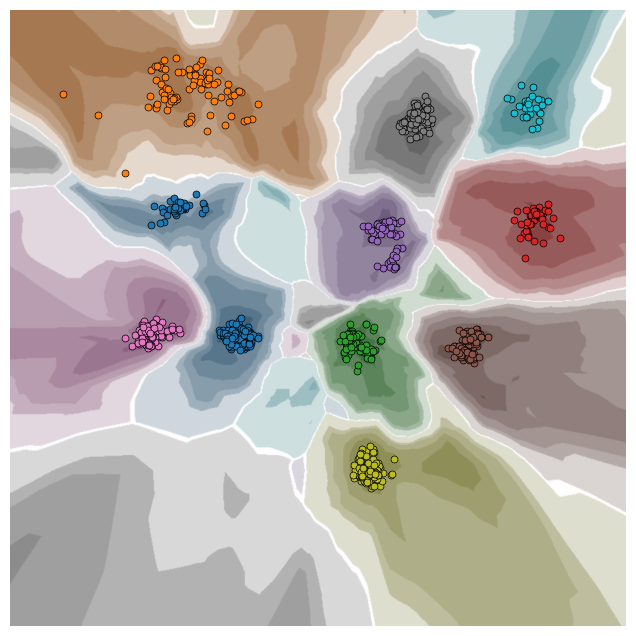

In [9]:
projector = VISProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='adjust_conf_vis', device=DEVICE)
# print('diff',diff[[[492, 783, 835, 871, 951, 1052,]]])

path = "/home/yifan/dataset/case_study_mnist_backdoor/clean_label.json"
with open(path, "r") as f:
    clean_label = json.load(f)
    
with open("/home/yifan/dataset/case_study_mnist_backdoor/noisy_label.json", "r") as f:
    noise_label = json.load(f)

noise_indicates = []
for i in range(len(clean_label)):
    if clean_label[i] != noise_label[i]:
        noise_indicates.append(i)

save_dir = os.path.join(data_provider.content_path, VIS_MODEL_NAME)
train_data = data_provider.train_representation(epoch)
labels = data_provider.train_labels(epoch)
train_data = train_data.reshape(train_data.shape[0],train_data.shape[1])
pred = data_provider.get_pred(epoch, train_data)
# pred = data_provider.get_pred(epoch,train_data)
new_pred_Res = pred.argmax(axis=1)
emb = projector.batch_project(epoch,train_data)
indicates = noise_indicates
print(indicates)
indicates = [492, 783, 835, 871, 951, 1052,]

sort_preds = np.sort(pred, axis=1)
diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])

inv = projector.batch_inverse(epoch, emb)
inv_pred = data_provider.get_pred(epoch, inv)
inv_pred_res = inv_pred.argmax(axis=1)
inv_sort_preds = np.sort(inv_pred, axis=1)
inv_diff = (inv_sort_preds[:, -1] - inv_sort_preds[:, -2]) / (inv_sort_preds[:, -1] - inv_sort_preds[:, 0])
conf_error_ = []
pred_error = []
for i in range(len(diff)):
    if abs(diff[i] - inv_diff[i]) > 0.2:
        conf_error_.append(i)
for i in range(len(diff)):
    if new_pred_Res[i] != inv_pred_res[i]:
        pred_error.append(i)
print("conf_error number123:", len(conf_error_),len(pred_error))
from singleVis.visualizer import visualizer
now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 
from singleVis.eval.evaluate import *
val = evaluate_proj_nn_perseverance_knn(train_data, emb, n_neighbors=15, metric="euclidean")
print("nn",val)
vis = visualizer(data_provider, projector, 800, "tab10")
vis.savefig_custom(epoch, path=os.path.join(save_dir, "{}_{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD,now)),
            pred=new_pred_Res[conf_error],
            train_labels=new_pred_Res[conf_error], 
            embedding=emb[conf_error])

In [10]:
val

1.60375

In [11]:
k=0
for i in range(len(conf_error)):
    index = conf_error[i]
    if abs(diff[index]-inv_diff[index]) > 0.2:
        k=k+1
print("current error:{}/{}".format(k,len(conf_error)))

current error:536/917


In [12]:
k=0
for i in range(len(train_data)):
    if abs(diff[i]-inv_diff[i]) > 0.2:
        k=k+1
print("total conf error:{}/{}".format(k,len(train_data)))

total conf error:848/60000


In [12]:
k=0
inv_pred_Res = inv_pred.argmax(axis=1)
for i in range(len(inv_pred_Res)):
    if inv_pred_Res[i] != new_pred_Res[i]:
        k=k+1
k

295

epoch 42
torch.Size([1, 1, 28, 28])
pred tensor([[0]], device='cuda:0')
pred tensor([[2]], device='cuda:0')
pred tensor([[2]], device='cuda:0')
pred tensor([[2]], device='cuda:0')
pred tensor([[1]], device='cuda:0')
pred tensor([[1]], device='cuda:0')
pred tensor([[1]], device='cuda:0')
pred tensor([[1]], device='cuda:0')
pred tensor([[1]], device='cuda:0')
pred tensor([[1]], device='cuda:0')
pred tensor([[1]], device='cuda:0')
pred tensor([[1]], device='cuda:0')
pred tensor([[1]], device='cuda:0')
pred tensor([[1]], device='cuda:0')
pred tensor([[1]], device='cuda:0')
pred tensor([[1]], device='cuda:0')
pred tensor([[1]], device='cuda:0')
pred tensor([[1]], device='cuda:0')
pred tensor([[1]], device='cuda:0')
pred tensor([[1]], device='cuda:0')
pred tensor([[1]], device='cuda:0')
pred tensor([[1]], device='cuda:0')
pred tensor([[1]], device='cuda:0')
pred tensor([[1]], device='cuda:0')
pred tensor([[1]], device='cuda:0')
pred tensor([[1]], device='cuda:0')
pred tensor([[1]], device='c

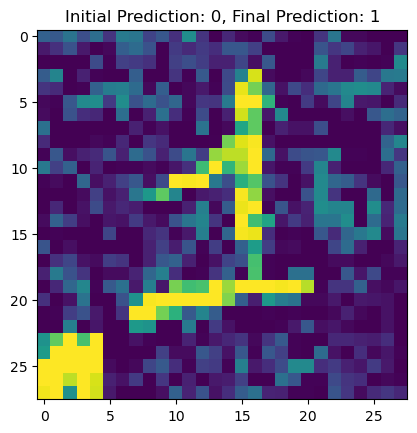

In [123]:
import sys
import os
import torch
import torch.nn as nn

sys.path.append(CONTENT_PATH)
import Model.model as subject_model
net = eval("subject_model.{}()".format('resnet18'))
import matplotlib.pyplot as plt
# 加载预训练模型
print("epoch",epoch)
model_location = os.path.join(CONTENT_PATH,'Model', "{}_{:d}".format('Epoch', epoch), "subject_model.pth")
net.load_state_dict(torch.load(model_location, map_location=torch.device("cpu")),strict=False)
net.eval()

train_data = torch.load(os.path.join(CONTENT_PATH, 'Training_data','training_dataset_data.pth'))
train_labels = torch.load(os.path.join(CONTENT_PATH, 'Training_data','training_dataset_label.pth'))
img_tensor = train_data[[24]]
img_label = train_labels[[24]]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
img_tensor = img_tensor.to(device)
img_label = img_label.to(device)
net = net.to(device)
print(img_tensor.shape)
# Set the target label to '1'
target_label = torch.tensor([1], dtype=torch.long).to(device)


loss_fn = torch.nn.CrossEntropyLoss()
# # 设置epsilon

epsilon = 0.01  # Smaller step size for iterative attack
num_steps = 50
# Set requires_grad attribute of tensor. Important for Attack
img_tensor.requires_grad = True
# Forward pass the data through the model
output = net(img_tensor)
init_pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
# If the initial prediction is already '1', no need to attack
steps = []
if init_pred.item() == 1:
    print("The initial prediction is already 1")
else:
    flag = 0
    for i in range(num_steps):
        # Zero all existing gradients
        net.zero_grad()
        # Forward pass
        rep = net.feature(img_tensor)
        output = net.prediction(rep)
        loss = loss_fn(output, target_label)
        # If misclassification has occurred, break out of the loop
        pred = output.max(1, keepdim=True)[1]
        print("pred",pred)
        steps.append(rep)
        if pred.item() == 1 and flag:
            print(f"Adversarial attack successful at step {i+1}!")
            # break
        # Backward pass
        loss.backward()

        # Apply perturbation
        img_tensor.data -= epsilon * img_tensor.grad.data.sign()  # Subtract to minimize the loss
        img_tensor.data = torch.clamp(img_tensor.data, 0, 1).to(device)
        # Clear gradients for next step
        img_tensor.grad.zero_()

    else:
        print("Failed to fool the model within the given steps.")
 
    # Display final result
    final_pred = net(img_tensor).max(1, keepdim=True)[1]
    perturbed_image_np = img_tensor.squeeze().detach().cpu().numpy()
    plt.imshow(perturbed_image_np)
    plt.title(f"Initial Prediction: {init_pred.item()}, Final Prediction: {final_pred.item()}")
    plt.show()

In [65]:
flag

0

Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 2293.22it/s]

pred [1]


In [76]:
adv_data

[array([-7.1977105, -3.257163 ], dtype=float32),
 array([-6.1176906, -3.187111 ], dtype=float32),
 array([-6.1298423, -3.1991856], dtype=float32),
 array([-6.155172 , -3.2358265], dtype=float32),
 array([-6.210756 , -3.2614703], dtype=float32),
 array([-6.2667856, -3.2886388], dtype=float32),
 array([-6.2969017, -2.8348162], dtype=float32),
 array([-6.953095 , -1.4225962], dtype=float32),
 array([-7.328386  ,  0.03194839], dtype=float32),
 array([-7.5523276 ,  0.46069413], dtype=float32),
 array([-7.7380404,  0.9502893], dtype=float32),
 array([-7.944302 ,  1.6445682], dtype=float32),
 array([-8.033011 ,  2.4876823], dtype=float32),
 array([-8.48581  ,  3.3525114], dtype=float32),
 array([-9.024787,  4.059628], dtype=float32),
 array([-9.524314 ,  4.6044025], dtype=float32),
 array([-9.942933 ,  5.0386996], dtype=float32),
 array([-10.40687 ,   5.706515], dtype=float32),
 array([-10.763749,   6.471987], dtype=float32)]

In [81]:
new_pred_Res[:19]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6])

In [127]:
print("pred:",labell)

pred: [0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 2910.69it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 2902.63it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 2709.50it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 2676.65it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 4048.56it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 2264.74it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 2272.10it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 2375.03it/s]

Successfully load the DVI visualization model for iteration 42



100%|██████████| 1/1 [00:00<00:00, 3201.76it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3086.32it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 4702.13it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3184.74it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 4644.85it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 4076.10it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3196.88it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3048.19it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 4718.00it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3663.15it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3172.70it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3393.45it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 4815.50it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3264.05it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3209.11it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 4837.72it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3211.57it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3175.10it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 2951.66it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3160.74it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3216.49it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3097.71it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3221.43it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3116.12it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3179.91it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 4771.68it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 4021.38it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3708.49it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 4848.91it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3045.97it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3148.88it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 4084.04it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3785.47it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 4588.95it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3615.78it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3908.95it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 4619.28it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 4843.31it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 3692.17it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 4634.59it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 4860.14it/s]


Successfully load the DVI visualization model for iteration 42


100%|██████████| 1/1 [00:00<00:00, 2900.63it/s]


Successfully load the DVI visualization model for iteration 42
Computing decision regions ...
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42
grid_samples (640000, 512)


100%|██████████| 3200/3200 [00:03<00:00, 931.12it/s] 


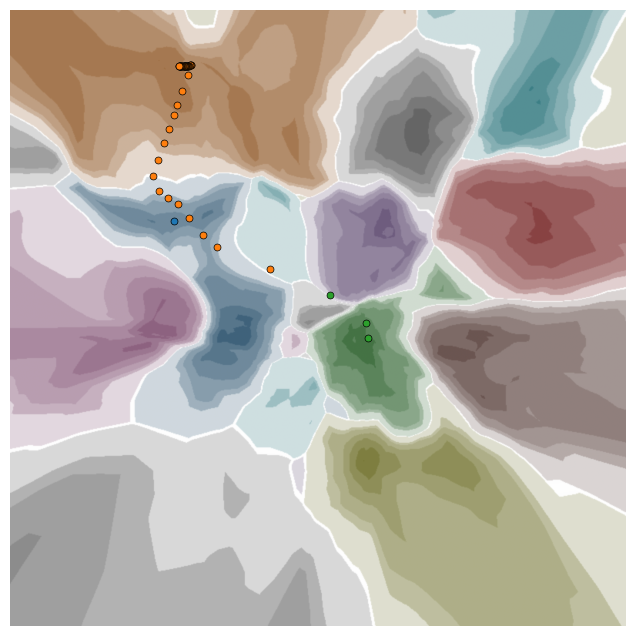

In [125]:
adv_data = []
labell = []
for i in range(50):
    if i%1==0:
        emb_adv = projector.batch_project(epoch,steps[i].detach().cpu().numpy())
        adv_data.extend(emb_adv)
        pred = data_provider.get_pred(epoch, steps[i].detach().cpu().numpy()).argmax(axis=1)
        labell.extend(pred)

# pred = data_provider.get_pred(epoch, steps[index].detach().cpu().numpy()).argmax(axis=1)
# print("pred",pred)
vis.savefig_custom(epoch, path=os.path.join(save_dir, "{}_{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD,now)),
            pred=np.array(labell),
            train_labels=np.array(labell), 
            embedding=np.array(adv_data))

In [118]:
indicates11 = np.where(new_pred_Res==0)[0]
indicates11

array([    1,    21,    23, ..., 59965, 59972, 59987])

34
Successfully load the DVI visualization model for iteration 42
Computing decision regions ...
Successfully load the DVI visualization model for iteration 42
Successfully load the DVI visualization model for iteration 42
grid_samples (640000, 512)


100%|██████████| 3200/3200 [00:03<00:00, 927.97it/s] 


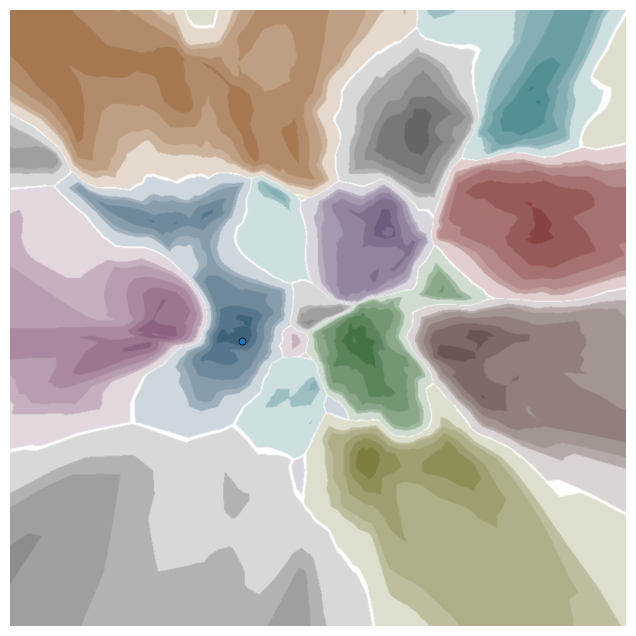

In [120]:
index_= indicates11 [4]
print(index_)
vis.savefig_custom(epoch, path=os.path.join(save_dir, "{}_{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD,now)),
            pred=new_pred_Res[[index_]],
            train_labels=new_pred_Res[[index_]], 
            embedding=emb[[index_]])